# Initialization

In [1]:
!pip install -q opendatasets pandas kaggle fastai fastxtend

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.3/149.3 kB 4.8 MB/s eta 0:00:00


In [1]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/alistairking/recyclable-and-household-waste-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

Your Kaggle Key:Dataset URL: https://www.kaggle.com/datasets/alistairking/recyclable-and-household-waste-classification


100%|██████████| 920M/920M [00:04<00:00, 223MB/s] 


In [3]:
from fastai.vision.all import *

In [4]:
from fastxtend.optimizer.lion import lion

In [6]:
path = Path('./recyclable-and-household-waste-classification/images/images')

In [7]:
path.ls()

(#30) [Path('recyclable-and-household-waste-classification/images/images/aerosol_cans'),Path('recyclable-and-household-waste-classification/images/images/aluminum_food_cans'),Path('recyclable-and-household-waste-classification/images/images/aluminum_soda_cans'),Path('recyclable-and-household-waste-classification/images/images/cardboard_boxes'),Path('recyclable-and-household-waste-classification/images/images/cardboard_packaging'),Path('recyclable-and-household-waste-classification/images/images/clothing'),Path('recyclable-and-household-waste-classification/images/images/coffee_grounds'),Path('recyclable-and-household-waste-classification/images/images/disposable_plastic_cutlery'),Path('recyclable-and-household-waste-classification/images/images/eggshells'),Path('recyclable-and-household-waste-classification/images/images/food_waste'),Path('recyclable-and-household-waste-classification/images/images/glass_beverage_bottles'),Path('recyclable-and-household-waste-classification/images/imag

## Training with ResNet

In [8]:
data = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(seed=42),
                 item_tfms=Resize(128),
                 batch_tfms=aug_transforms(min_scale=0.75),
                 get_y=(lambda o: Path(o).parents[1].name)
                )

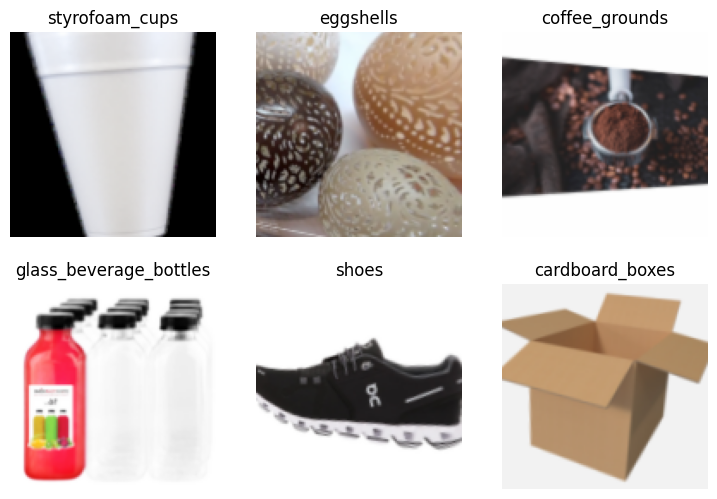

In [9]:
dls = data.dataloaders(path)
dls.show_batch(max_n=6)

In [10]:
# print one image and label
img, label = dls.train_ds[0]
print(label)
print(img)

TensorCategory(20)
PILImage mode=RGB size=256x256


In [9]:
vocab = dls.vocab
vocab

['aerosol_cans', 'aluminum_food_cans', 'aluminum_soda_cans', 'cardboard_boxes', 'cardboard_packaging', 'clothing', 'coffee_grounds', 'disposable_plastic_cutlery', 'eggshells', 'food_waste', 'glass_beverage_bottles', 'glass_cosmetic_containers', 'glass_food_jars', 'magazines', 'newspaper', 'office_paper', 'paper_cups', 'plastic_cup_lids', 'plastic_detergent_bottles', 'plastic_food_containers', 'plastic_shopping_bags', 'plastic_soda_bottles', 'plastic_straws', 'plastic_trash_bags', 'plastic_water_bottles', 'shoes', 'steel_food_cans', 'styrofoam_cups', 'styrofoam_food_containers', 'tea_bags']

In [10]:
learn = vision_learner(dls, 'resnet26d', metrics=error_rate).to_fp16()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/64.2M [00:00<?, ?B/s]

SuggestedLRs(valley=0.0010000000474974513, slide=6.918309736647643e-06)

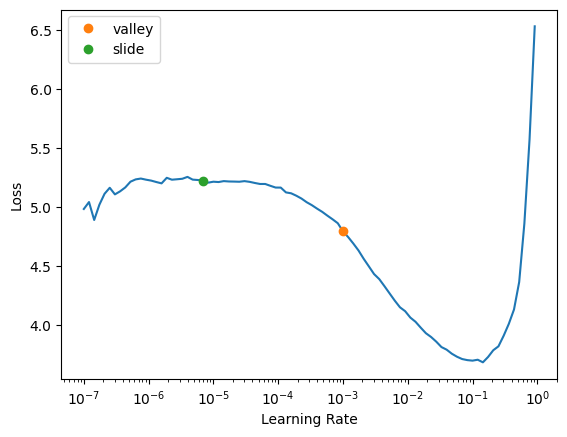

In [11]:
learn.lr_find(suggest_funcs=(valley, slide))

In [12]:
learn.fine_tune(3, 0.002)

epoch,train_loss,valid_loss,error_rate,time
0,1.878231,1.226592,0.352000,00:52


epoch,train_loss,valid_loss,error_rate,time
0,1.228698,0.965398,0.285000,00:54
1,0.976768,0.803758,0.244667,00:54
2,0.785030,0.767922,0.238333,00:54


In [13]:
def train(arch, item, batch, epochs=5):
    data = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(seed=42),
                 item_tfms=item,
                 batch_tfms=batch,
                 get_y=(lambda o: Path(o).parents[1].name)
                )
    dls = data.dataloaders(path)
    learn = vision_learner(dls, arch, metrics=error_rate).to_fp16()
    learn.fine_tune(epochs, 0.002)
    return learn

In [14]:
learn = train('resnet26d', Resize(128), aug_transforms(min_scale=0.75))

epoch,train_loss,valid_loss,error_rate,time
0,1.871984,1.266431,0.350333,00:53


epoch,train_loss,valid_loss,error_rate,time
0,1.246431,0.954022,0.287667,00:53


KeyboardInterrupt: 

## Training with ConvNext

In [ ]:
learn = train('convnext_small_in22k', Resize(192), aug_transforms(size=128, min_scale=0.75))

model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.12/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,error_rate,time
0,1.059844,0.570994,0.168333,01:16


epoch,train_loss,valid_loss,error_rate,time
0,0.575569,0.458380,0.149000,01:19
1,0.476414,0.407756,0.134667,01:11
2,0.346343,0.387867,0.119000,01:12
3,0.274873,0.368321,0.120333,01:09
4,0.225458,0.361143,0.114000,01:13


In [ ]:
valid = learn.dls.valid
preds, targs = learn.get_preds(dl=valid)

In [ ]:
error_rate(preds, targs)

TensorBase(0.1140)

## Adding Test-Time Augmentation
i.e. adding data augmentation to test data before we predict.

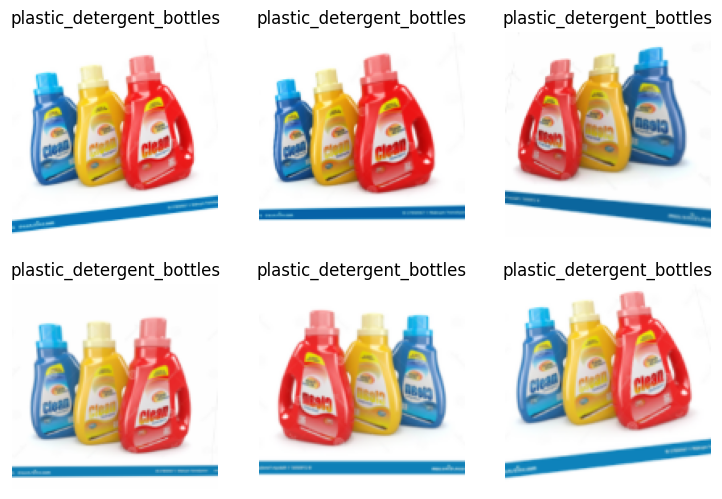

In [ ]:
learn.dls.train.show_batch(max_n=6, unique=True)

In [ ]:
tta_preds, _ = learn.tta(dl=valid)

In [ ]:
error_rate(tta_preds, targs)

TensorBase(0.1047)

## Scaling up the model

In [ ]:
learn = train('convnext_small_in22k', Resize(256), aug_transforms(size=192, min_scale=0.75))

epoch,train_loss,valid_loss,error_rate,time
0,0.852100,0.437025,0.145333,01:21


epoch,train_loss,valid_loss,error_rate,time
0,0.435903,0.353481,0.122000,01:33
1,0.373369,0.341678,0.113000,01:28
2,0.285178,0.306853,0.100333,01:30
3,0.202599,0.294587,0.101333,01:28
4,0.167608,0.290747,0.100333,01:28


In [ ]:
tta_preds, _ = learn.tta(dl=valid)
error_rate(tta_preds, targs)

TensorBase(0.0950)

## Adding gradient accumulation

Instead of updating the weights after every batch, keep accumulating the gradients for a few batches, and then update the weights with those accumulated gradients. This allows us to use larger models while not being limited by GPU RAM.

In [18]:
set_seed(727)

In [19]:
def get_grandparent_name(f):
    return Path(f).parents[1].name

def train(arch, accum=1, finetune=True, lr_find=False, get_learner=False, epochs=5, lr=0.002):
    data = DataBlock(
            blocks=(ImageBlock, CategoryBlock),
            get_items=get_image_files,
            splitter=RandomSplitter(seed=727),
            batch_tfms=aug_transforms(size=224, min_scale=0.75),
            get_y=get_grandparent_name,
        )
    dls = data.dataloaders(
        path,
        bs=64//accum # divide batch size by `accum` to effectively get the same batch size, but using less memory
    )
    # 64 = number of items to calculate gradients with before updating the weights
    cbs = [GradientAccumulation(64)] if accum else []
    cbs.append(EarlyStoppingCallback(patience=3))
    learn = vision_learner(dls, arch, metrics=error_rate, cbs=cbs, opt_func=lion(foreach=True)).to_fp16()
    if get_learner:
        return learn
    elif lr_find:
        return learn.lr_find(suggest_funcs=(valley, slide))
    elif finetune:
        learn.fine_tune(epochs, lr)
        return learn, learn.tta(dl=dls.valid)
    else:
        learn.unfreeze()
        learn.fit_one_cycle(epochs, lr)
    return learn

In [20]:
import gc
def report_gpu():
    print(torch.cuda.list_gpu_processes())
    gc.collect()
    torch.cuda.empty_cache()

## Explore possible models for ensembling

In [ ]:
# https://huggingface.co/timm/convnextv2_base.fcmae_ft_in22k_in1k
train('convnextv2_nano.fcmae_ft_in22k_in1k', epochs=1, finetune=False)
report_gpu()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/62.5M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,4.048314,4.042034,0.968667,01:58


GPU:0
process       8088 uses     5416.000 MB GPU memory


In [ ]:
# https://huggingface.co/timm/vit_small_patch16_dinov3.lvd1689m
train('vit_small_patch16_dinov3.lvd1689m', epochs=1, finetune=False)
report_gpu()

epoch,train_loss,valid_loss,error_rate,time
0,3.934115,3.301577,0.911333,01:09


GPU:0
process       8088 uses     3818.000 MB GPU memory


In [ ]:
# https://huggingface.co/timm/vit_base_patch16_224.augreg2_in21k_ft_in1k
train('vit_small_patch16_224.augreg_in21k_ft_in1k', epochs=1, finetune=False)
report_gpu()

epoch,train_loss,valid_loss,error_rate,time
0,3.896650,3.244457,0.879667,00:51


GPU:0
process       8088 uses     3650.000 MB GPU memory


In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Ensembling

In [21]:
# tensor([27, 15, 24,  ..., 17, 21, 22])
learner = train('convnextv2_nano.fcmae_ft_in22k_in1k', get_learner=True)
_, labels = learner.get_preds(dl=learner.dls.valid)
print(labels)

model.safetensors:   0%|          | 0.00/62.5M [00:00<?, ?B/s]

tensor([27, 15, 24,  ..., 17, 21, 22])


In [22]:
gc.collect()
torch.cuda.empty_cache()

convnextv2_nano.fcmae_ft_in22k_in1k SuggestedLRs(valley=0.0003981071640737355, slide=3.981071586167673e-06)


vit_small_patch16_dinov3.lvd1689m SuggestedLRs(valley=0.0010000000474974513, slide=6.918309736647643e-06)


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

vit_base_patch16_224.augreg2_in21k_ft_in1k SuggestedLRs(valley=0.0004786300996784121, slide=0.0008317637839354575)


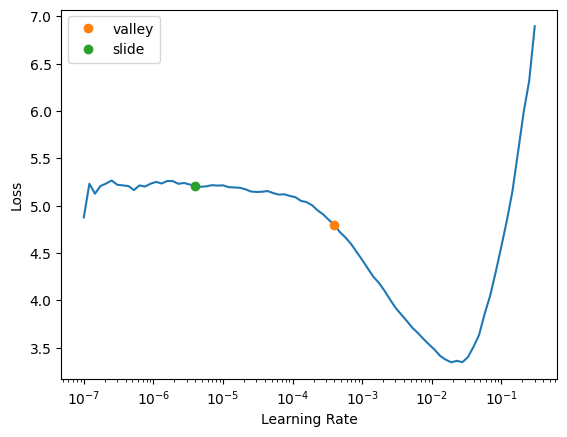

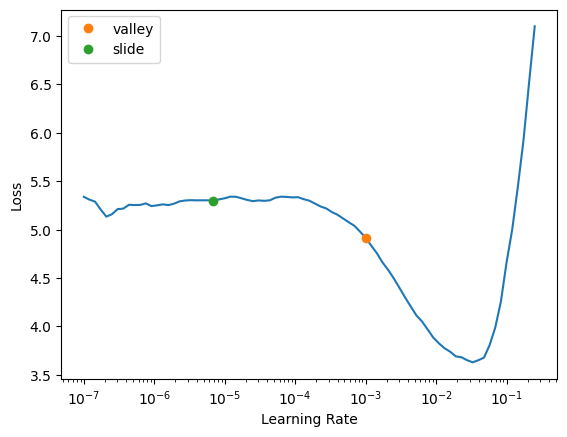

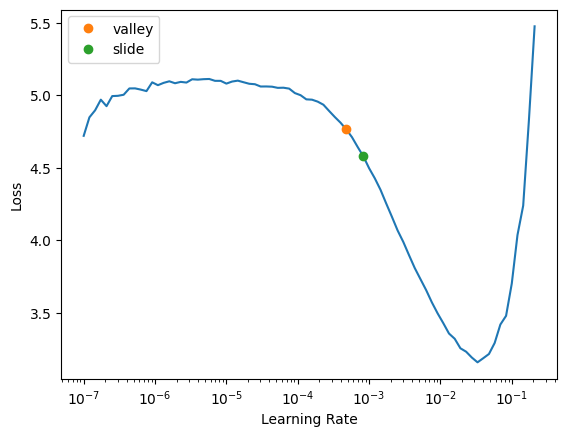

In [ ]:
for arch in ['convnextv2_nano.fcmae_ft_in22k_in1k', 'vit_small_patch16_dinov3.lvd1689m', 'vit_base_patch16_224.augreg2_in21k_ft_in1k']:
    print(arch, train(arch, lr_find=True))
    gc.collect()
    torch.cuda.empty_cache()

In [23]:
tta_res = []
learners = []

def add_to_ensemble(arch, amount=1, accum=1, epochs=15, lr=0.001):
    for i in range(amount):
        print('---', arch)
        print(f'Model #{i + 1}')
        learn, tta_res_ = train(arch, epochs=epochs, accum=accum, lr=lr)
        learners.append(learn)
        tta_res.append(tta_res_)
        gc.collect()
        torch.cuda.empty_cache()

In [ ]:
add_to_ensemble('convnextv2_nano.fcmae_ft_in22k_in1k', amount=1, lr=0.0005)

--- convnextv2_nano.fcmae_ft_in22k_in1k
Model #1


epoch,train_loss,valid_loss,error_rate,time
0,1.131198,0.588136,0.176667,01:20


epoch,train_loss,valid_loss,error_rate,time
0,0.628628,0.481088,0.157667,01:30
1,0.483526,0.396136,0.138667,01:30
2,0.364613,0.370163,0.121000,01:28
3,0.280824,0.363294,0.119333,01:28
4,0.253022,0.366658,0.113333,01:29
5,0.218482,0.376645,0.111667,01:29
6,0.204800,0.366968,0.107333,01:30


No improvement since epoch 3: early stopping


In [ ]:
learners[0].loss_func, learners[0].opt_func

(FlattenedLoss of CrossEntropyLoss(),
 functools.partial(<function Lion at 0x7b2d9f56b7e0>, beta1=0.9, beta2=0.99, wd=0.1, foreach=True, eightbit=False))

In [ ]:
add_to_ensemble('vit_small_patch16_dinov3.lvd1689m', amount=1, lr=0.0005)

--- vit_small_patch16_dinov3.lvd1689m
Model #1


epoch,train_loss,valid_loss,error_rate,time
0,1.299788,0.631132,0.181667,00:57


epoch,train_loss,valid_loss,error_rate,time
0,0.677273,0.477559,0.151333,01:05
1,0.529765,0.387335,0.125667,01:05
2,0.417762,0.337383,0.116000,01:05
3,0.359683,0.319304,0.104667,01:05
4,0.325994,0.346140,0.115000,01:07
5,0.280478,0.329205,0.107667,01:06
6,0.249439,0.328099,0.106333,01:06


No improvement since epoch 3: early stopping


In [ ]:
add_to_ensemble('vit_base_patch16_224.augreg2_in21k_ft_in1k', amount=1, lr=0.0005)

--- vit_base_patch16_224.augreg2_in21k_ft_in1k
Model #1


epoch,train_loss,valid_loss,error_rate,time
0,1.067929,0.553275,0.162333,01:28


epoch,train_loss,valid_loss,error_rate,time
0,0.540043,0.381510,0.132333,01:56
1,0.348046,0.320406,0.112000,01:55
2,0.268509,0.299548,0.103667,01:57
3,0.227630,0.342918,0.109000,01:56
4,0.210032,0.340212,0.104333,01:56
5,0.164213,0.364647,0.103333,01:56


No improvement since epoch 2: early stopping


In [ ]:
save_pickle('learners.pkl', learners)

In [ ]:
save_pickle('tta_res.pkl', tta_res)

In [24]:
learners = load_pickle('/content/drive/MyDrive/4al3/learners.pkl')

In [25]:
tta_res = load_pickle('/content/drive/MyDrive/4al3/tta_res.pkl')

In [26]:
tta_prs = first(zip(*tta_res))

In [27]:
_, targs = tta_res[0]
targs.shape

torch.Size([3000])

In [28]:
targs

tensor([27, 15, 24,  ..., 17, 21, 22])

In [29]:
tta_res[1][1]

tensor([27, 15, 24,  ..., 17, 21, 22])

In [30]:
avg_pr = torch.stack(tta_prs).mean(0)
avg_pr.shape

torch.Size([3000, 30])

In [31]:
idxs = avg_pr.argmax(dim=1)
idxs.shape

torch.Size([3000])

In [32]:
acc = (idxs == targs).float().mean()
acc, 1 - acc

(tensor(0.9093), tensor(0.0907))

In [33]:
from sklearn.metrics import ConfusionMatrixDisplay

In [34]:
vocab = learners[0].dls.vocab

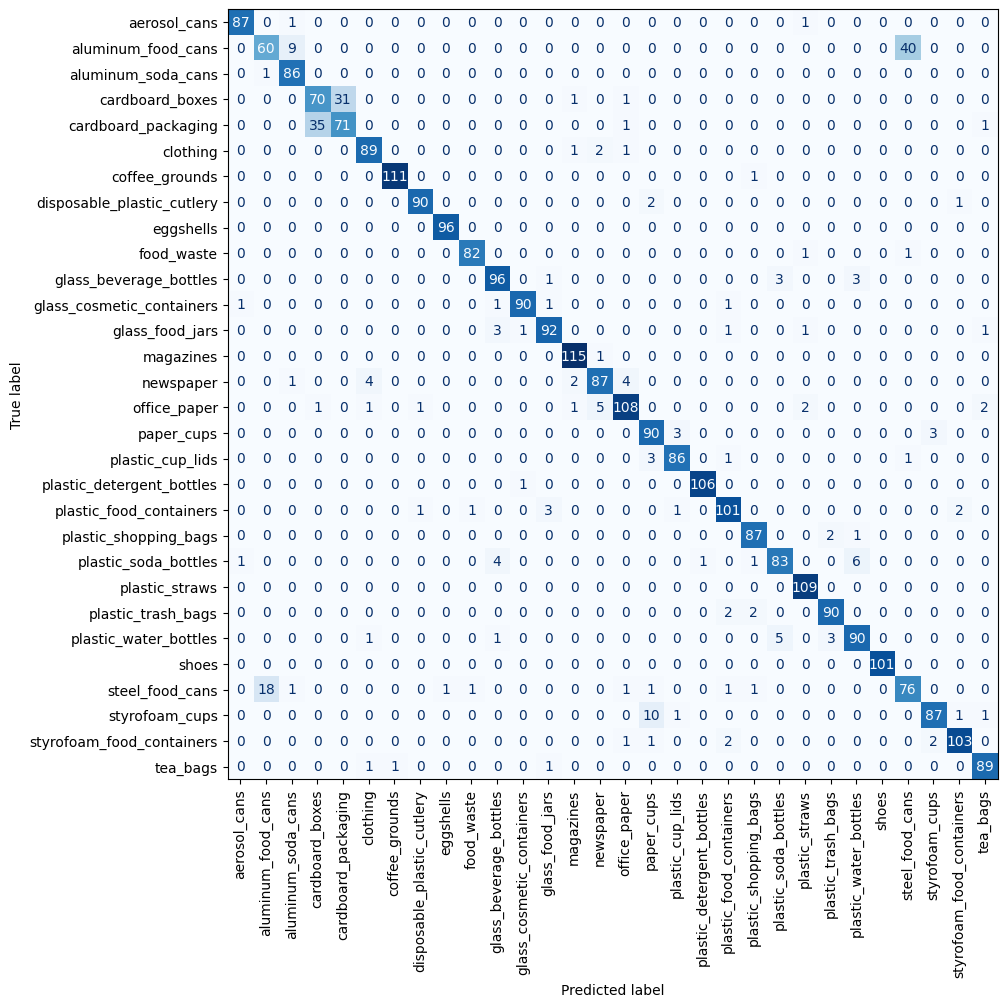

In [35]:
fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(targs, idxs, display_labels=vocab, xticks_rotation='vertical', cmap='Blues', ax=ax, colorbar=False)

In [39]:
def translate_num_to_text(y):
    return [vocab[i] for i in y]

def translate(y):
    new_y = []
    for label in y:
        if label in ['disposable_plastic_cutlery', 'plastic_detergent_bottles', 'plastic_food_containers',
                     'plastic_shopping_bags', 'plastic_soda_bottles', 'plastic_straws', 'plastic_trash_bags',
                     'plastic_water_bottles', 'aerosol_cans', 'aluminum_food_cans', 'aluminum_soda_cans',
                     'steel_food_cans', 'paper_cups', 'plastic_cup_lids', 'glass_beverage_bottles',
                     'glass_cosmetic_containers', 'glass_food_jars']:
            new_y.append('containers')
        elif label in ['cardboard_boxes', 'cardboard_packaging', 'magazines', 'newspaper', 'office_paper', ]:
            new_y.append('papers')
        elif label in ['coffee_grounds', 'eggshells', 'food_waste', 'tea_bags']:
            new_y.append('green_bin')
        elif label in ['clothing', 'shoes', 'styrofoam_cups', 'styrofoam_food_containers']:
            new_y.append('waste')

    return new_y

In [40]:
idxs_general = translate(translate_num_to_text(idxs))
targs_general = translate(translate_num_to_text(targs))

In [41]:
correct = 0
for i in range(len(idxs_general)):
    if idxs_general[i] == targs_general[i]:
        correct += 1

print(f'{correct / len(idxs_general):.4f}')

0.9837


In [42]:
categories = ['containers', 'papers', 'green_bin', 'waste']
total_precision = 0
total_recall = 0
total_accuracy = 0
total_f1 = 0
print('---')
for cat in categories:
    tp, tn, fp, fn = 0, 0, 0, 0
    for i in range(len(idxs_general)):
        if idxs_general[i] == cat:
            if targs_general[i] == cat:
                tp += 1
            else:
                fp += 1
        else:
            if targs_general[i] == cat:
                fn += 1
            else:
                tn += 1
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)
    total_precision += precision
    total_recall += recall
    total_accuracy += accuracy
    total_f1 += f1
    print(f'{cat} accuracy: {accuracy:.4f}')
    print(f'{cat} precision: {precision:.4f}')
    print(f'{cat} recall: {recall:.4f}')
    print(f'{cat} f1: {f1:.4f}')
    print('---')

print(f'average accuracy: {total_accuracy / len(categories):.4f}')
print(f'average precision: {total_precision / len(categories):.4f}')
print(f'average recall: {total_recall / len(categories):.4f}')
print(f'average f1: {total_f1 / len(categories):.4f}')

---
containers accuracy: 0.9887
containers precision: 0.9869
containers recall: 0.9928
containers f1: 0.9898
---
papers accuracy: 0.9940
papers precision: 0.9889
papers recall: 0.9780
papers f1: 0.9834
---
green_bin accuracy: 0.9957
green_bin precision: 0.9793
green_bin recall: 0.9870
green_bin f1: 0.9831
---
waste accuracy: 0.9890
waste precision: 0.9672
waste recall: 0.9504
waste f1: 0.9587
---
average accuracy: 0.9918
average precision: 0.9806
average recall: 0.9770
average f1: 0.9788


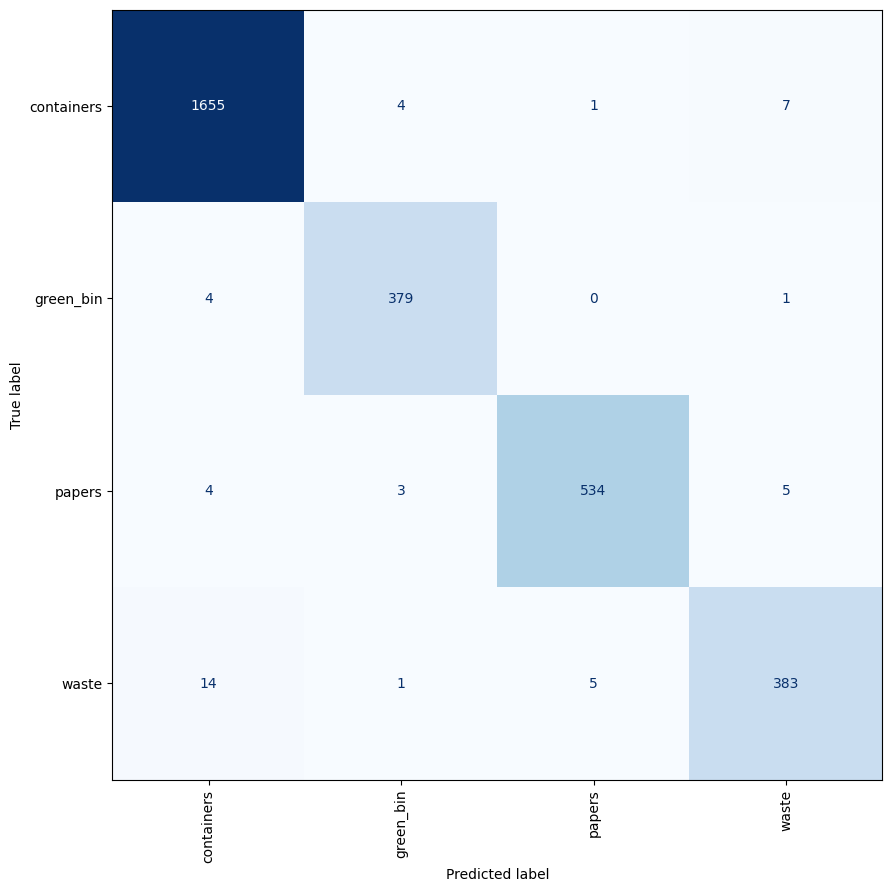

In [43]:
fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(targs_general, idxs_general, xticks_rotation='vertical', cmap='Blues', ax=ax, colorbar=False)